## Topic modelling using Gensim

Topic Modelling is different from rule-based text mining approaches that use regular expressions or dictionary based keyword searching techniques. 

It is an unsupervised approach used for finding and observing the bunch of words (called “topics”) in large clusters of texts.

Topics can be defined as “a repeating pattern of co-occurring terms in a corpus”. 

A good topic model should result in – “health”, “doctor”, “patient”, “hospital” for a topic – Healthcare,
and “farm”, “crops”, “wheat” for a topic – “Farming”.

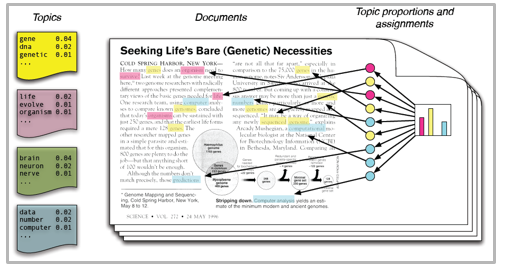

We would be using latent Dirichlet allocation (LDA) to find the topics from documents.

* Latent Dirichlet allocation (LDA) is a generative statistical model.
* It allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar. 

If observations are words collected into documents:

* It posits that each document is a mixture of a small number of topics
* And that each word's creation is attributable to one of the document's topics.




In [1]:
import numpy as np
import logging
import pyLDAvis.gensim
import json
import warnings
import os
warnings.filterwarnings('ignore')  # To ignore all warnings that arise here to enhance clarity
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer

from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from gensim import corpora, models
from gensim.corpora.dictionary import Dictionary
from numpy import array

### Set up logging

In [2]:
logger = logging.getLogger()
logger.setLevel(logging.ERROR)
logging.debug("test")

### Set up corpus

As stated in table 2 from [this](http://www.cs.bham.ac.uk/~pxt/IDA/lsa_ind.pdf) paper, this corpus essentially has two classes of documents. 

* First set of our documents are from enron emails.
* Second set of documents are scientific papers.

### Experimental setup 
We will be setting up two LDA models. 
* One with 50 iterations of training 
* the other with just 1. 

Hence the one with 50 iterations ("better" model) should be able to capture this underlying pattern of the corpus better than the "bad" LDA model.

Therefore, in theory, topic coherence for the good LDA model should be greater than the one for the bad LDA model.

In [3]:

class MyCorpus(corpora.TextCorpus):
    def __init__(self, input=None, path = 'assets/topicmodelling/'):
        self.path = path
        super(corpora.TextCorpus, self).__init__()
        self.input = input
        self.dictionary = Dictionary()
        self.metadata = False
        self.dictionary.add_documents(self.get_texts())

    def __len__(self):
        files = os.listdir(self.path)
        return len(files)

    def get_texts(self):
        files = os.listdir(self.path)
        counteR = 0
        json_data={}
        for fl in files:
            #print(counteR, ': ', fl)
            if(counteR%1000 == 0):
                print(counteR)
            counteR += 1
            text = ''
            input_file = open(self.path + '/'+fl, errors='ignore')
            dat = input_file.read()
            yield ie_preprocess(dat)

def ie_preprocess(document):
    document = re.sub('[^A-Za-z ]+', '', document)
    document = [stemmer.stem(w) for w in nltk.word_tokenize(document) if w.lower() not in stop]
    return document



### Initialize stopwords and stemmer to pre process the documents.

In [4]:
    stop = stopwords.words('english')
    add_stopwords = ['said', 'mln', 'billion', 'million', 'pct', 'would', 'inc', 'company', 'corp']
    stop += add_stopwords
    stemmer = EnglishStemmer()


## This would all our corpus above and create dictionary

In [5]:
corpus = MyCorpus()

0


### Set up two topic models

We'll be setting up two different LDA Topic models. A good one and bad one. To build a "good" topic model, we'll simply train it using more iterations than the bad one. Therefore the `u_mass` coherence should in theory be better for the good model than the bad one since it would be producing more "human-interpretable" topics.

In [6]:
goodLdaModel = LdaModel(corpus=corpus, id2word=corpus.dictionary, iterations=50, num_topics=2, minimum_probability=0)

0


In [7]:
badLdaModel = LdaModel(corpus=corpus, id2word=corpus.dictionary, iterations=1, num_topics=2, minimum_probability=0)

0


### Using U_Mass Coherence to check how well is our model trained

In [8]:
goodcm = CoherenceModel(model=goodLdaModel, corpus=corpus, dictionary=corpus.dictionary, coherence='u_mass')

In [9]:
badcm = CoherenceModel(model=badLdaModel, corpus=corpus, dictionary=corpus.dictionary, coherence='u_mass')

### Interpreting the topics

As we will see below using LDA visualization, the better model comes up with two topics composed of the following words:
1. goodLdaModel:
    - __Topic 1__: More weightage assigned to words such as "enron", "kevin", "color", "rate" etc which captures the first set of documents.
    - __Topic 2__: More weightage assigned to words such as "learn", "al", "model" which captures the topic in the second set of documents.
2. badLdaModel:
    - __Topic 1__: More weightage assigned to words such as "et", "feature", "event", "model" which doesn't make the topic clear enough.
    - __Topic 2__: More weightage assigned to words such as "et", "feature", "event", "model" which is similar to the first topic. Hence both topics are not human-interpretable.

Therefore, the topic coherence for the goodLdaModel should be greater for this than the badLdaModel since the topics it comes up with are more human-interpretable. 

### Visualize topic models

In [10]:
pyLDAvis.enable_notebook()

In [11]:
pyLDAvis.gensim.prepare(goodLdaModel, corpus, corpus.dictionary)

0
0


PreparedData(topic_coordinates=           Freq  cluster  topics         x    y
topic                                          
1      81.51799        1       1  0.009265  0.0
0      18.48201        1       2 -0.009265  0.0, topic_info=     Category        Freq      Term       Total  loglift  logprob
term                                                             
1505  Default  145.000000     event  145.000000  30.0000  30.0000
7436  Default  182.000000     train  182.000000  29.0000  29.0000
6122  Default  156.000000     enron  156.000000  28.0000  28.0000
4585  Default  252.000000     relat  252.000000  27.0000  27.0000
4609  Default  400.000000        et  400.000000  26.0000  26.0000
3005  Default   96.000000   corefer   96.000000  25.0000  25.0000
530   Default   69.000000   mention   69.000000  24.0000  24.0000
7201  Default  291.000000       use  291.000000  23.0000  23.0000
886   Default   66.000000   trigger   66.000000  22.0000  22.0000
6736  Default  336.000000        al  336.000000  21.0000  21.0000
5572  Default   66.000000    detect   66.000000  20.0000  20.0000
4524  Default  445.000000     model  445.000000  19.0000  19.0000
6829  Default  232.000000    semant  232.000000  18.0000  18.0000
143   Default  105.000000   program  105.000000  17.0000  17.0000
264   Default   86.000000       one   86.000000  16.0000  16.0000
6681  Default  163.000000      task  163.000000  15.0000  15.0000
2246  Default  199.000000       ect  199.000000  14.0000  14.0000
1273  Default   86.000000    entiti   86.000000  13.0000  13.0000
3843  Default   88.000000    result   88.000000  12.0000  12.0000
334   Default  123.000000       set  123.000000  11.0000  11.0000
4879  Default   92.000000   sentenc   92.000000  10.0000  10.0000
6766  Default  102.000000    comput  102.000000   9.0000   9.0000
2934  Default   66.000000    compon   66.000000   8.0000   8.0000
5430  Default  110.000000   extract  110.000000   7.0000   7.0000
6643  Default   79.000000    system   79.000000   6.0000   6.0000
966   Default  112.000000       two  112.000000   5.0000   5.0000
2240  Default  139.000000    featur  139.000000   4.0000   4.0000
5308  Default   81.000000      pars   81.000000   3.0000   3.0000
3594  Default   69.000000      type   69.000000   2.0000   2.0000
1078  Default  105.000000    inform  105.000000   1.0000   1.0000
...       ...         ...       ...         ...      ...      ...
264    Topic2   22.218458       one   86.226334   0.3323  -5.9092
4918   Topic2    7.335698  independ   21.727163   0.6026  -7.0173
4585   Topic2   48.245018     relat  252.416077   0.0336  -5.1338
3798   Topic2    6.052609      plan   17.275303   0.6396  -7.2096
2934   Topic2   17.037596    compon   66.250999   0.3303  -6.1747
143    Topic2   24.000605   program  105.565681   0.2071  -5.8320
1273   Topic2   20.372540    entiti   86.172699   0.2462  -5.9959
4571   Topic2   10.324904     three   35.506325   0.4532  -6.6755
4609   Topic2   58.438866        et  400.927582  -0.2374  -4.9421
3843   Topic2   19.527653    result   88.824265   0.1735  -6.0382
6758   Topic2    7.003336     power   21.198944   0.5808  -7.0637
7201   Topic2   44.529270       use  291.821014  -0.1916  -5.2139
6736   Topic2   46.649952        al  336.486572  -0.2875  -5.1674
4879   Topic2   19.261456   sentenc   92.687469   0.1172  -6.0520
3594   Topic2   15.776439      type   69.653397   0.2034  -6.2516
4524   Topic2   52.409248     model  445.633667  -0.4520  -5.0510
6829   Topic2   34.412292    semant  232.258224  -0.2211  -5.4717
6681   Topic2   27.141357      task  163.051315  -0.1046  -5.7090
6766   Topic2   20.064796    comput  102.515381   0.0573  -6.0111
334    Topic2   22.269970       set  123.347107  -0.0234  -5.9068
2246   Topic2   29.675474       ect  199.077408  -0.2150  -5.6198
6643   Topic2   17.093273    system   79.682838   0.1490  -6.1714
5430   Topic2   19.897356   extract  110.711205  -0.0280  -6.0195
1653   Topic2   31.730814      word  288.968323  -0.5207  -5.5528
421

In [12]:
pyLDAvis.gensim.prepare(badLdaModel, corpus, corpus.dictionary)

0
0


PreparedData(topic_coordinates=            Freq  cluster  topics         x    y
topic                                           
1      54.324905        1       1  0.002924  0.0
0      45.675091        1       2 -0.002924  0.0, topic_info=     Category        Freq       Term       Total  loglift  logprob
term                                                              
6122  Default  169.000000      enron  169.000000  30.0000  30.0000
7256  Default   83.000000       text   83.000000  29.0000  29.0000
3230  Default  105.000000       work  105.000000  28.0000  28.0000
1653  Default  257.000000       word  257.000000  27.0000  27.0000
2119  Default  109.000000        hou  109.000000  26.0000  26.0000
4015  Default  184.000000    languag  184.000000  25.0000  25.0000
4609  Default  378.000000         et  378.000000  24.0000  24.0000
2934  Default   71.000000     compon   71.000000  23.0000  23.0000
7426  Default   53.000000    consist   53.000000  22.0000  22.0000
459   Default   59.000000     machin   59.000000  21.0000  21.0000
2917  Default   43.000000       sinc   43.000000  20.0000  20.0000
4164  Default   82.000000  distribut   82.000000  19.0000  19.0000
1911  Default   97.000000          c   97.000000  18.0000  18.0000
264   Default   93.000000        one   93.000000  17.0000  17.0000
2246  Default  188.000000        ect  188.000000  16.0000  16.0000
4320  Default  159.000000  represent  159.000000  15.0000  15.0000
6799  Default  158.000000     vector  158.000000  14.0000  14.0000
4901  Default   61.000000   knowledg   61.000000  13.0000  13.0000
1522  Default   19.000000        way   19.000000  12.0000  12.0000
4879  Default   94.000000    sentenc   94.000000  11.0000  11.0000
966   Default  112.000000        two  112.000000  10.0000  10.0000
7136  Default   73.000000     includ   73.000000   9.0000   9.0000
2741  Default   18.000000    transit   18.000000   8.0000   8.0000
4213  Default  224.000000      learn  224.000000   7.0000   7.0000
1505  Default  189.000000      event  189.000000   6.0000   6.0000
1178  Default   41.000000    support   41.000000   5.0000   5.0000
2906  Default  105.000000     differ  105.000000   4.0000   4.0000
699   Default   39.000000     achiev   39.000000   3.0000   3.0000
2471  Default   34.000000   introduc   34.000000   2.0000   2.0000
6937  Default   38.000000          r   38.000000   1.0000   1.0000
...       ...         ...        ...         ...      ...      ...
1911   Topic2   51.435066          c   97.164764   0.1475  -5.9745
264    Topic2   49.714054        one   93.806763   0.1487  -6.0085
4609   Topic2  182.750809         et  378.419312   0.0557  -4.7067
1436   Topic2   17.178560      david   30.882286   0.1971  -7.0712
1178   Topic2   22.824520    support   41.788269   0.1788  -6.7870
4320   Topic2   80.129471  represent  159.735046   0.0937  -5.5312
2246   Topic2   93.320023        ect  188.482605   0.0806  -5.3788
6799   Topic2   78.510345     vector  158.164001   0.0832  -5.5516
699    Topic2   21.453112     achiev   39.281254   0.1787  -6.8490
4879   Topic2   48.621845    sentenc   94.862892   0.1153  -6.0308
7136   Topic2   38.299828     includ   73.813622   0.1275  -6.2694
4213   Topic2  105.870499      learn  224.527023   0.0318  -5.2526
1505   Topic2   90.414566      event  189.796722   0.0421  -5.4104
2906   Topic2   52.226822     differ  105.158554   0.0837  -5.9592
6829   Topic2  101.519951     semant  220.642426   0.0073  -5.2946
7436   Topic2   91.652550      train  196.826324   0.0193  -5.3968
4524   Topic2  171.531677      model  407.037170  -0.0805  -4.7701
1273   Topic2   45.304974     entiti   91.731956   0.0782  -6.1014
6736   Topic2  131.424866         al  317.267761  -0.0977  -5.0364
7201   Topic2  117.480080        use  280.521027  -0.0868  -5.1486
56     Topic2   54.617306    perform  115.627045   0.0336  -5.9145
2240   Topic2   61.548908     featur  133.555847   0.0089  -5.7950
6766   Topic2   49.757336     comput  103.708496   0.0492  -6.0077
4585   To

In [13]:
print(goodcm.get_coherence())

0
-2.301717143335696


In [14]:
print(badcm.get_coherence())

0
-1.4188193109539793


## Predicting unseen documents using LDAModel 

In the end topic modelling tries to predict what is the probability of this document being from the found topic.

Topics in topic modelling is an abstract concept and is very different from what we image as topics.


### Type of documents:

1. Enron Emails : Files starting with P17
2. ACL anthology : Files starting with 00112

Here as we saw above one topic represents emails and one topic represents scientific papers.

When we try to predict a unknown document, We will get topic for document as probability over all found topic

Document Topic =  (probability of document being from topic 1)X Topic1 + (Probability of document being from topic 2)X Topic2

### Expectation 

 * Good LDA model i.e well trained model for 50 iteration should have correctly predict the topic of document 
 * Bad LDA model under trained mode should give random or equal probability for both the topics.

We are testing our model on unseen documents present in topicmodellingtest



In [15]:
files = os.listdir('assets/topicmodellingtest')
for fl in files:
    input_file = open('assets/topicmodellingtest' + '/'+fl, errors='ignore')
    dat = input_file.read()
    idocdow = corpus.dictionary.doc2bow(ie_preprocess(dat))
    prediction = goodLdaModel[idocdow]
    print("File : ", fl, " Prediction ", str(prediction))


File :  .DS_Store  Prediction  [(0, 0.49999875), (1, 0.5000012)]
File :  0109.2000-01-07.kaminski.ham.txt  Prediction  [(0, 0.95304316), (1, 0.04695687)]
File :  0112.1999-12-31.farmer.ham.txt  Prediction  [(0, 0.949702), (1, 0.05029799)]
File :  0112.2001-03-06.kitchen.ham.txt  Prediction  [(0, 0.9594932), (1, 0.040506788)]
File :  0113.2001-03-06.kitchen.ham.txt  Prediction  [(0, 0.9951991), (1, 0.0048009525)]
File :  0116.2001-03-07.kitchen.ham.txt  Prediction  [(0, 0.5343351), (1, 0.46566492)]
File :  0119.2000-01-04.farmer.ham.txt  Prediction  [(0, 0.98242134), (1, 0.017578613)]
File :  P17-1176.pdf.json  Prediction  [(0, 0.004903869), (1, 0.9950961)]
File :  P17-1177.pdf.json  Prediction  [(0, 0.057066027), (1, 0.942934)]
File :  P17-1178.pdf.json  Prediction  [(0, 0.16296355), (1, 0.83703643)]
File :  P17-1179.pdf.json  Prediction  [(0, 0.0009285536), (1, 0.9990715)]


In [16]:
files = os.listdir('assets/topicmodellingtest')
for fl in files:
    input_file = open('assets/topicmodellingtest' + '/'+fl, errors='ignore')
    dat = input_file.read()
    idocdow = corpus.dictionary.doc2bow(ie_preprocess(dat))
    prediction = badLdaModel[idocdow]
    print("File : ", fl, " Prediction ", str(prediction))


File :  .DS_Store  Prediction  [(0, 0.50000024), (1, 0.4999998)]
File :  0109.2000-01-07.kaminski.ham.txt  Prediction  [(0, 0.43157545), (1, 0.5684245)]
File :  0112.1999-12-31.farmer.ham.txt  Prediction  [(0, 0.49547005), (1, 0.50452995)]
File :  0112.2001-03-06.kitchen.ham.txt  Prediction  [(0, 0.42775166), (1, 0.5722484)]
File :  0113.2001-03-06.kitchen.ham.txt  Prediction  [(0, 0.4546653), (1, 0.54533476)]
File :  0116.2001-03-07.kitchen.ham.txt  Prediction  [(0, 0.4574061), (1, 0.5425939)]
File :  0119.2000-01-04.farmer.ham.txt  Prediction  [(0, 0.4996802), (1, 0.5003198)]
File :  P17-1176.pdf.json  Prediction  [(0, 0.462134), (1, 0.537866)]
File :  P17-1177.pdf.json  Prediction  [(0, 0.5255268), (1, 0.4744732)]
File :  P17-1178.pdf.json  Prediction  [(0, 0.44755605), (1, 0.552444)]
File :  P17-1179.pdf.json  Prediction  [(0, 0.48721746), (1, 0.51278245)]
